# Optimizer - cavity modes


Run Optimizer instance with id: opt id 

Starting optimizer with 1 provided measurement dependencies and 1 fit parameter(s):

  no. |                           id |       initial value |              min |              max
    0 |             Pt top thickness |                   3 |                0 |               10

Using 0 equality constraint(s) on parameter(s):

Using 0 inequality constraint(s).

Residual start value: 0.0207539


Calling ceres solver with fit method LevMar

Ceres Solver Report: Iterations: 15, Initial cost: 2.153615e-04, Final cost: 1.042534e-05, Termination: CONVERGENCE

Optimizer finished with 1 fit parameter(s):

  no. |                           id |           fit value |       initial value |              min |              max
    0 |             Pt top thickness |             2.41489 |                   3 |                0 |               10

and 0 equality constraint(s) on parameter(s):

and 0 inequality constraint(s).

Optimized residual from 0.0207539 

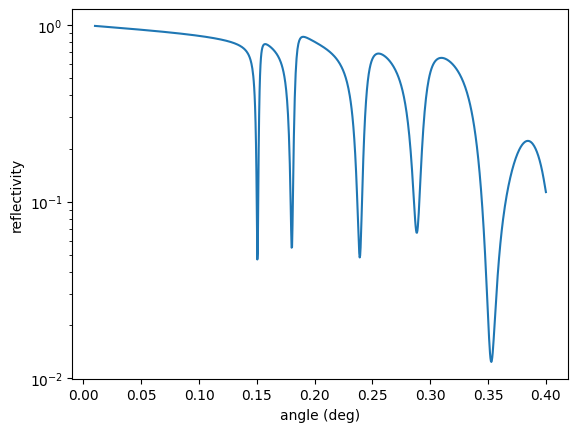

In [1]:
import nexus as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# ------------------------- layers --------------------------

# the initial guess for the top layer is 3 nm here
# set it to a Var object with reasonable bounds
lay_Pt_top = nx.Layer(id = "Pt top",
                      material = nx.Material.Template(nx.lib.material.Pt),
                      thickness = nx.Var(3, min = 0, max = 10, fit = True, id = "Pt top thickness"))

lay_B4C = nx.Layer(id = "B4C",
                   material = nx.Material.Template(nx.lib.material.B4C),
                   thickness = 15)

lay_Fe = nx.Layer(id = "Fe",
                  material = nx.Material.Template(nx.lib.material.Fe_enriched),
                  thickness = 2)

lay_Pt_bottom = nx.Layer(id = "Pt bottom",
                         material = nx.Material.Template(nx.lib.material.Pt),
                         thickness = 15)

lay_substrate = nx.Layer(id = "substrate",
                         material = nx.Material.Template(nx.lib.material.Si),
                         thickness = nx.inf)

sample = nx.Sample(id = "cavity",
                   layers = [lay_Pt_top,
                             lay_B4C,
                             lay_Fe,
                             lay_B4C,
                             lay_Pt_bottom,
                             lay_substrate],
                   geometry = "r")

beam  = nx.Beam()
beam.LinearSigma()

exp = nx.Experiment(beam = beam,
                    objects = sample,
                    id = "my exp")

# initialize a reflectivity object used for the optimization
angles = np.linspace(0.01, 0.4, 1001)

reflectivity = nx.Reflectivity(experiment = exp,
                               sample = sample,
                               energy = nx.lib.energy.Fe57,
                               angles = angles)

# setup the optimizer
class NexusOptimizer(nx.Optimizer):
    def __init__(self, measurements, id):
        super().__init__(measurements, id)

    # the defienition of the residual calculation
    def Residual(self):
        # calculate the reflectivity
        intensity = reflectivity()
        # get the index of the 1st minimum
        min_index_1st = np.squeeze(argrelextrema(intensity, np.less))[0]
        # get the index of the 3rd minimum
        min_index_3rd = np.squeeze(argrelextrema(intensity, np.less))[2]
        # optimize for the intensity at both positions
        residual = intensity[min_index_1st]**2 + intensity[min_index_3rd]**2
        return residual

# pass the reflectivity object to the optimizer
opt = NexusOptimizer(measurements = [reflectivity],
                     id = "opt id")

# let's just use a local gradient-free algorithm here
opt.options.method = "LevMar"

# run the optimization
opt.Evaluate()  # or simply call opt()

plt.semilogy(angles, reflectivity.result)
plt.xlabel('angle (deg)')
plt.ylabel('reflectivity')
plt.show()